## Estimate Kubelka-Munk parameters from paint mixtures

In [ ]:
import pandas as pd
from pathlib import Path

# TODO: update this path to the location of the dataset on your system
dataset_path = Path('/local/home/rwiersma/Documents/Paintings/Captures paintings 2023')

# Read the csv file conainting the paintout reflectances
with (dataset_path / 'processed' / 'paintouts_reflectance.csv').open() as file:
    paintouts_reflectance = pd.read_csv(file)

paintouts_reflectance = paintouts_reflectance[paintouts_reflectance['background'] == 'white']
paintout_names = paintouts_reflectance['name'].unique()

print(paintout_names)

['Titanium white' 'Bone black' 'Chalk white' 'French Ochre 40030'
 'French Ochre JALS 40060' 'Lapis Lazuli from chile' 'Raw umber greenish'
 'Red lake' 'Indigo' 'Jaune de reseda' 'Krapplack red']


In [3]:
from painting_tools.rendering import kubelka_munk_opaque
from painting_tools.util import spectral_to_rgb, resample_wavelengths

# Utility function to render mixtures of paints
def render_mixtures(w, k_and_s, wavelengths):
    """
    Renders an image with Kubelka-Munk, given:
    w : jax.numpy array, mixing weights.
        [N, P] N number of pixels, P number of pigments
    k_and_s : jax.numpy array, absorption and scattering coefficient per pigment and wavelength.
        [P, L, 2] P number of pigments, L number of wavelengts
    """
    w = w / w.sum(axis=-1, keepdims=True).clip(1e-15)          # [N, P]
    k_and_s = (w[..., None, None] * k_and_s[None]).sum(axis=1) # [N, P, 1, 1] x [1, P, L, 2] -> [N, P, L, 2] -> [N, L, 2]
    k, s = k_and_s[..., 0], k_and_s[..., 1]                    # [N, L, 2] -> [N, L], [N, L]
    reflection = kubelka_munk_opaque(k[None], s[None]) # [1, N, L]
    return spectral_to_rgb(reflection, wavelengths)[0]

Titanium white
Bone black


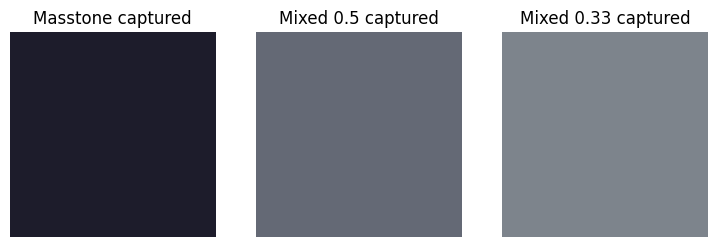

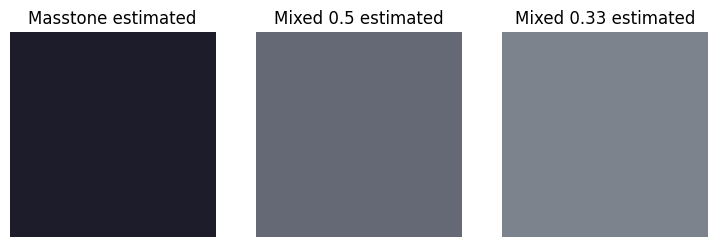

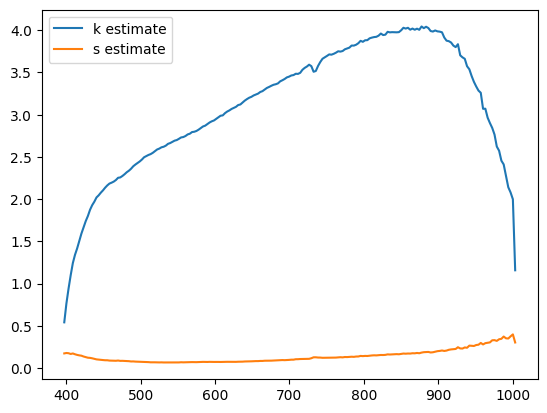

Chalk white


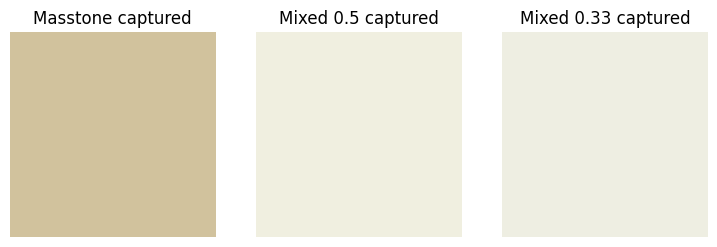

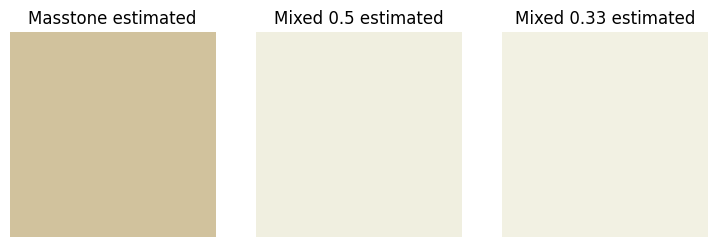

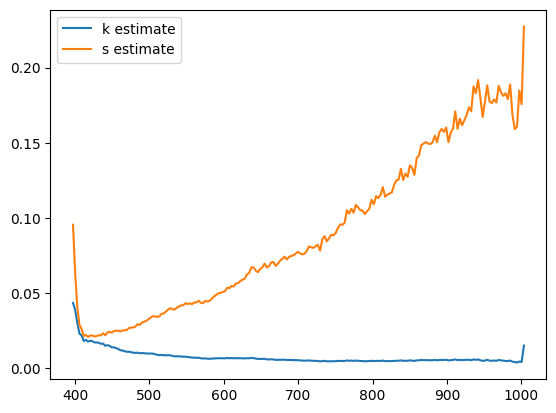

French Ochre 40030


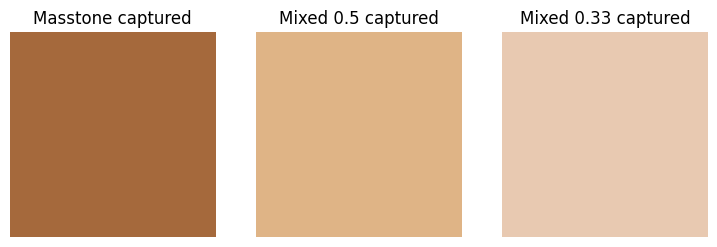

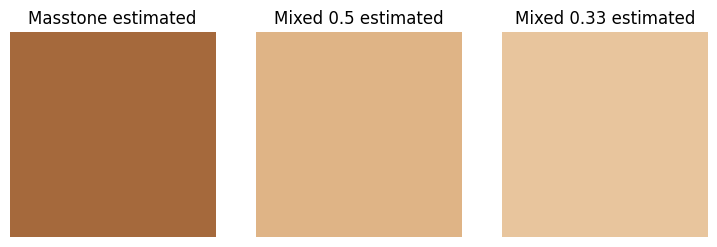

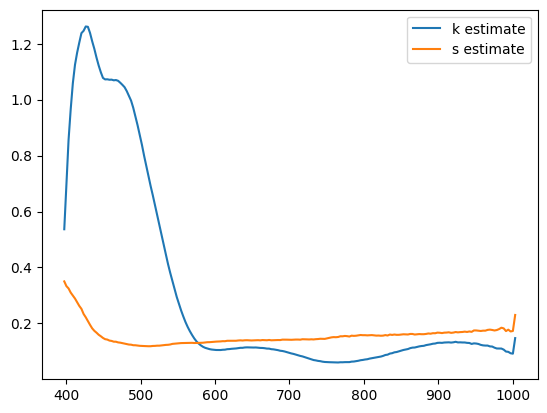

French Ochre JALS 40060


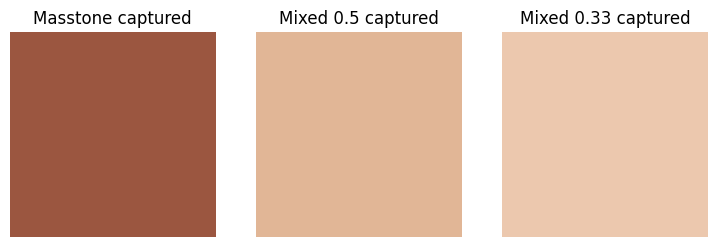

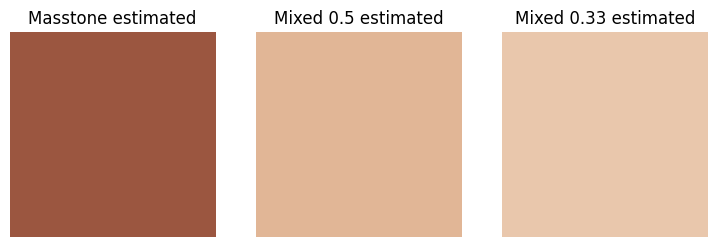

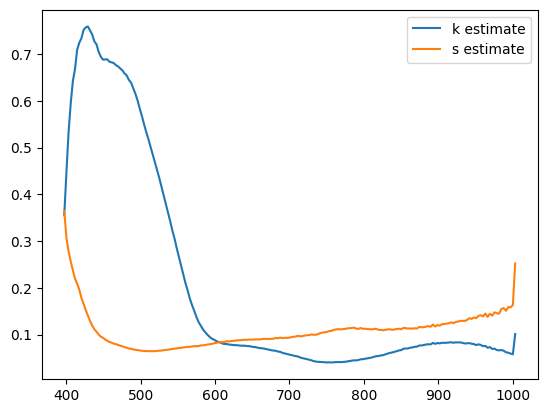

Lapis Lazuli from chile


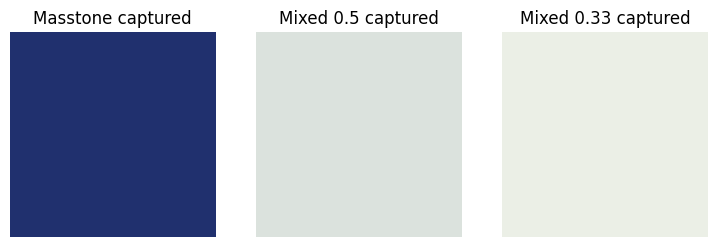

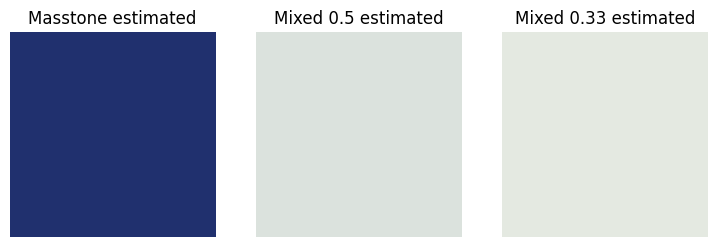

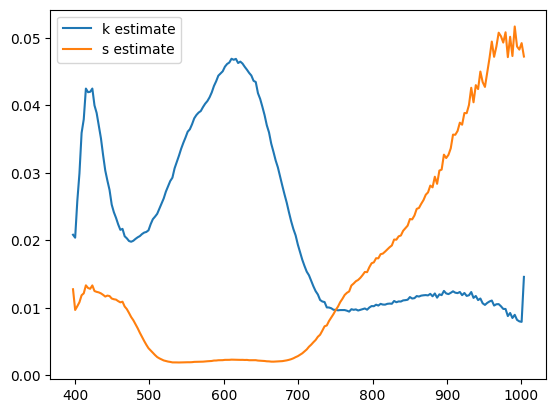

Raw umber greenish


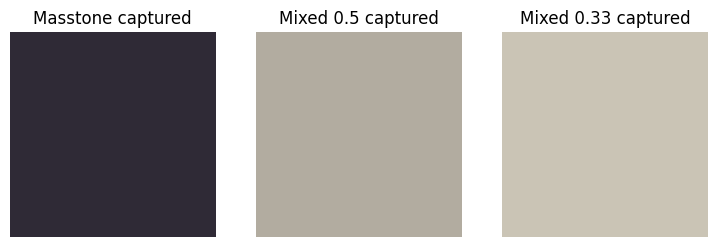

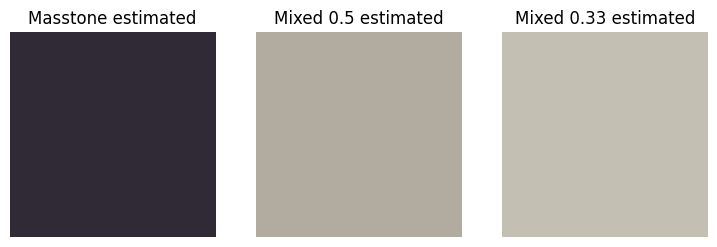

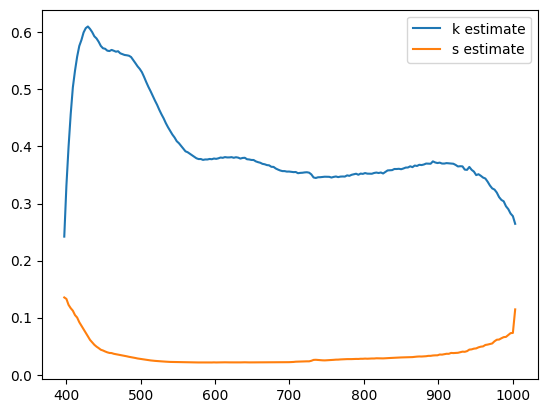

Red lake


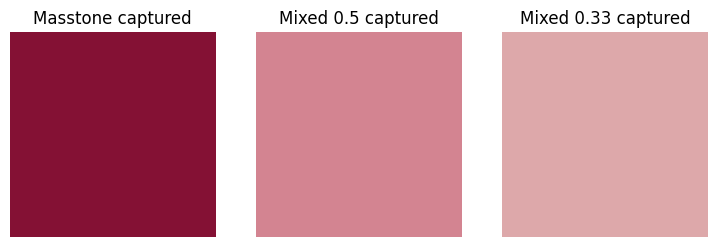

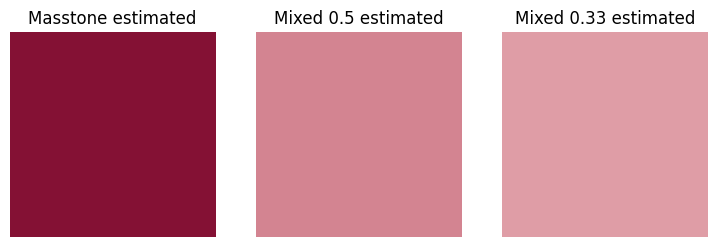

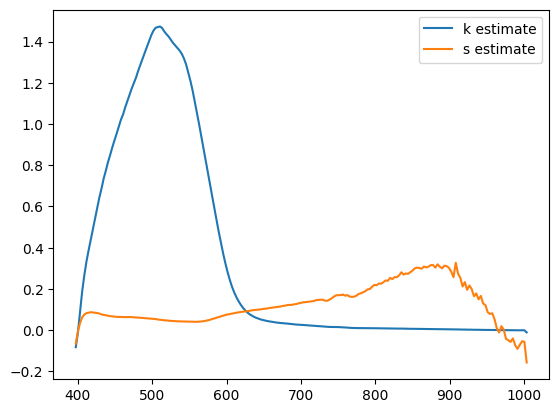

Indigo


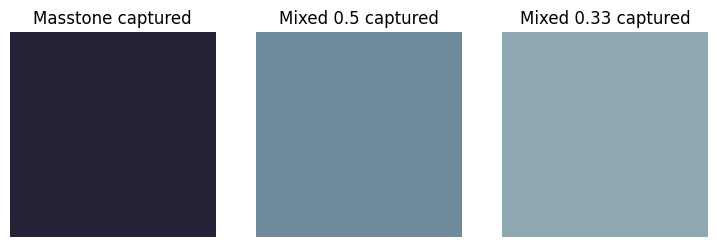

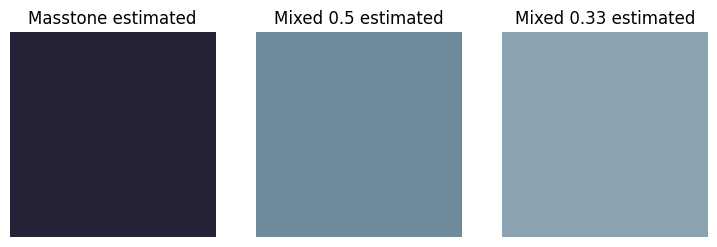

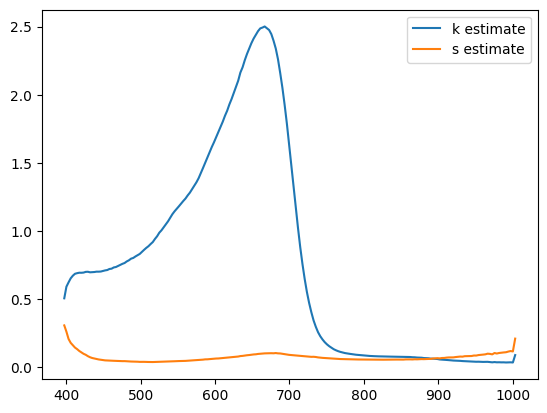

Jaune de reseda


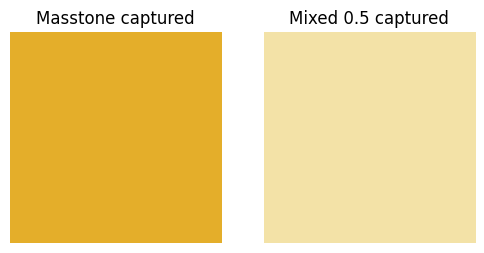

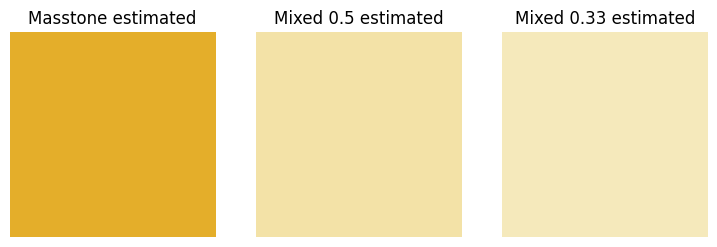

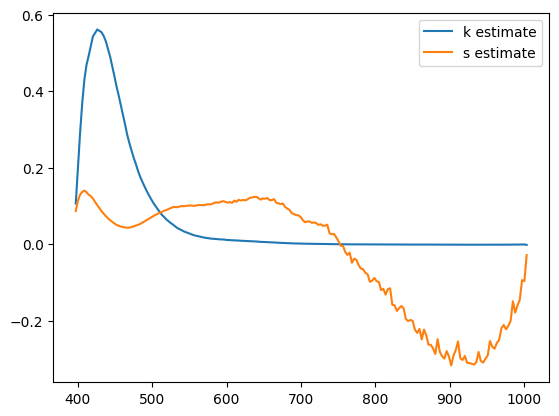

Krapplack red


: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from painting_tools.rendering.kubelka_munk import reflectance_to_ks
from painting_tools.util import spectral_to_rgb, show_colors

# Get reflectance of titanium white. We'll assume scattering is 1 for all wavelengths for titanium.
white_reflectance = paintouts_reflectance[paintouts_reflectance['name'] == 'Titanium white'].iloc[:, 3:].values[0]
k_white = reflectance_to_ks(white_reflectance)
s_white = np.ones_like(k_white)
wavelengths = paintouts_reflectance.columns[3:].values.astype(np.float32)

# Write wavelengths to spectra.txt file in database folder
np.savetxt(dataset_path / 'processed' / 'spectra.txt', wavelengths)
# Create string with k and s values starting with the name, followed by all k values and then all s values, separated by a tab
result = '"Titanium white"\t' + '\t'.join([str(k) for k in k_white]) + '\t' + '\t'.join([str(s) for s in s_white]) + '\n'

# get first color
for paintout_name in paintout_names:
    print(paintout_name)
    paintout_set = paintouts_reflectance[paintouts_reflectance['name'] == paintout_name]
    masstone = paintout_set[paintout_set['ratio_pigment_to_white'] == 1.0]
    # select all ratios within distance 0.01 of 0.5
    mixed_05 = paintout_set[(paintout_set['ratio_pigment_to_white'] >= 0.49) & (paintout_set['ratio_pigment_to_white'] <= 0.51)]
    mixed_033 = paintout_set[(paintout_set['ratio_pigment_to_white'] >= 0.32) & (paintout_set['ratio_pigment_to_white'] <= 0.34)]

    # Get all the reflectance values, all the columns after the third
    if masstone.shape[0] < 1:
        continue
    masstone_reflectance = masstone.iloc[:, 3:].values[0]

    mixed_05_reflectance = None
    if mixed_05.shape[0] == 1:
        mixed_05_reflectance = mixed_05.iloc[:, 3:].values[0]
        ratio_05 = mixed_05['ratio_pigment_to_white'].values[0]

    mixed_033_reflectance = None
    if mixed_033.shape[0] == 1:
        mixed_033_reflectance = mixed_033.iloc[:, 3:].values[0]
        ratio_033 = mixed_033['ratio_pigment_to_white'].values[0]

    if mixed_05_reflectance is None and mixed_033_reflectance is None:
        continue
    if mixed_05_reflectance is None:
        k_s_mix = reflectance_to_ks(mixed_033_reflectance)
        ratio = ratio_033
    else:
        k_s_mix = reflectance_to_ks(mixed_05_reflectance)
        ratio = ratio_05

    k_s_masstone = reflectance_to_ks(masstone_reflectance)

    s_estimate = (1 - ratio) / ratio * (k_s_mix * s_white - k_white) / (k_s_masstone - k_s_mix)
    k_estimate = k_s_masstone * s_estimate

    result += f'"{paintout_name}"\t' + '\t'.join([str(k) for k in k_estimate]) + '\t' + '\t'.join([str(s) for s in s_estimate]) + '\n'

    # Visualization
    # Get color of each paintout
    captured_rgb = [spectral_to_rgb(masstone_reflectance, wavelengths)]
    captured_names = ['Masstone captured']
    if mixed_05_reflectance is not None:
        captured_rgb.append(spectral_to_rgb(mixed_05_reflectance, wavelengths))
        captured_names.append('Mixed 0.5 captured')
    if mixed_033_reflectance is not None:
        captured_rgb.append(spectral_to_rgb(mixed_033_reflectance, wavelengths))
        captured_names.append('Mixed 0.33 captured')
    show_colors(captured_rgb, captured_names)

    # Recreate color of each paintout
    k_and_s = np.stack([
        np.stack([k_estimate, s_estimate], axis=-1),
        np.stack([k_white, s_white], axis=-1)
        ], axis=0)
    mixture_weights = np.array([1.0, ratio_05, ratio_033])
    mixture_weights = np.array([mixture_weights, 1 - mixture_weights]).T
    estimated_mixtures_rgb = render_mixtures(mixture_weights, k_and_s, wavelengths)

    show_colors([estimated_mixtures_rgb[i] for i in range(3)], ['Masstone estimated', 'Mixed 0.5 estimated', 'Mixed 0.33 estimated'])

    # Show k and s estimates
    plt.plot(wavelengths, k_estimate, label='k estimate')
    plt.plot(wavelengths, s_estimate, label='s estimate')
    plt.legend()
    plt.show()

with (dataset_path / 'processed' / 'oilpaint.rs').open('w') as file:
    file.write(result)